# Восстановление золота из руды

Необходимо подготовить прототип ML модели, которая будет предсказать коэффициент восстановления золота из руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

План работы:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler

In [ ]:
try:
    train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
    test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
    full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

In [ ]:
dfs = [full, train, test]
names = ['full', 'train', 'test']

In [ ]:
for name, df in zip(names, dfs):
    print(f'{name.title():>5} : {df.shape}')

 Full : (19439, 87)
Train : (14149, 87)
 Test : (5290, 53)


In [ ]:
full.shape[0] == train.shape[0] + test.shape[0]

True

In [ ]:
(full.columns == train.columns).all(), test.columns.isin(full.columns).all()

(True, True)

Общая информация о данных:

In [ ]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [ ]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [ ]:
for name, df in zip(names, dfs):
    print(f'{f" {name.title()} Data ":=^23}')
    print('Full duplicates:', df.duplicated().sum())
    print('Date duplicates:', df['date'].duplicated().sum())

====== Full Data ======
Full duplicates: 0
Date duplicates: 0
===== Train Data ======
Full duplicates: 0
Date duplicates: 0
====== Test Data ======
Full duplicates: 0
Date duplicates: 0


Полностью повторяющихся строк или дат в данных нет.

In [ ]:
cols = train.columns.to_series().str.split('.', expand=True)
cols1 = test.columns.to_series().str.split('.', expand=True)
for stage in ['rougher', 'primary_cleaner', 'secondary_cleaner', 'final']:
    print(stage)
    for param_type in ['input', 'output', 'state', 'calculation']:
        ps = cols[(cols[0] == stage) & (cols[1] == param_type)][2].sort_values()
        if not ps.empty:
            ps1 = cols1[(cols1[0] == stage) & (cols1[1] == param_type)][2]
            print('===' if ps1.empty else '---', param_type)
            for param in ps:
                if param in ps1.values:
                    print('--- ---', param)
                else:
                    print('=== ===', param)

rougher
--- input
--- --- feed_ag
--- --- feed_au
--- --- feed_pb
--- --- feed_rate
--- --- feed_size
--- --- feed_sol
--- --- floatbank10_sulfate
--- --- floatbank10_xanthate
--- --- floatbank11_sulfate
--- --- floatbank11_xanthate
=== output
=== === concentrate_ag
=== === concentrate_au
=== === concentrate_pb
=== === concentrate_sol
=== === recovery
=== === tail_ag
=== === tail_au
=== === tail_pb
=== === tail_sol
--- state
--- --- floatbank10_a_air
--- --- floatbank10_a_level
--- --- floatbank10_b_air
--- --- floatbank10_b_level
--- --- floatbank10_c_air
--- --- floatbank10_c_level
--- --- floatbank10_d_air
--- --- floatbank10_d_level
--- --- floatbank10_e_air
--- --- floatbank10_e_level
--- --- floatbank10_f_air
--- --- floatbank10_f_level
=== calculation
=== === au_pb_ratio
=== === floatbank10_sulfate_to_au_feed
=== === floatbank11_sulfate_to_au_feed
=== === sulfate_to_au_concentrate
primary_cleaner
--- input
--- --- depressant
--- --- feed_size
--- --- sulfate
--- --- xanthate
===

В тестовых данных отсутствуют признаки типов `output` и `calculation`.

Признаки типа `output` - параметры выходного продукта на каждом этапе. Они напрямую связаны с целевым признаком, поэтому их нельзя использовать для обучения модели, т.к. это будет утечкой целевого признака.

Признаки типа `calculation` - расчётные характеристики. Они также не нужны для обучения, т.к. расчитываются из уже имеющихся данных, поэтому будут сильно коррелировать с ними.

In [ ]:
def missing():
    return (pd.concat([df.isna().sum() for df in dfs], axis=1)
       .fillna(0).astype(int)[lambda x: (x > 0).any(axis=1)]
       .set_axis(names, axis=1)
       .style.background_gradient('YlOrRd'))
missing()

,full,train,test
final.output.concentrate_ag,1,1,0
final.output.concentrate_pb,1,1,0
final.output.concentrate_sol,211,211,0
final.output.tail_ag,1,0,0
final.output.tail_pb,101,100,0
final.output.tail_sol,6,5,0
primary_cleaner.input.sulfate,24,20,4
primary_cleaner.input.depressant,37,32,5
primary_cleaner.input.xanthate,104,100,4
primary_cleaner.output.concentrate_pb,116,86,0


Пропусков достаточно много. Так, как соседние по времени параметры похожи, можно интерполировать пропущеные зачения по времени.

In [ ]:
_dfs = []
for df in dfs:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.interpolate(method='time')
    assert (df.isna().sum() == 0).all()
    _dfs.append(df)
dfs = _dfs
missing()

,full,train,test


In [ ]:
full, train, test = dfs

Проверка формулы расчёта `recovery`.

In [ ]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

recovery = c*(f-t)/(f*(c-t))
recovery.mean()

0.8270450164550291

In [ ]:
train['rougher.output.recovery'].mean()

82.70450164550293

In [ ]:
mae = mean_absolute_error(recovery, train['rougher.output.recovery']/100)
mae, np.isclose(mae, 0)

(1.0787996288450409e-16, True)

Эффективность обогащения (`recovery`) рассчитана правильно.

Выбираем нужные признаки из данных:

In [ ]:
features0 = test.columns[test.columns.str.startswith('rougher')]
features1 = test.columns
target0 = 'rougher.output.recovery'
target1 = 'final.output.recovery'
seed = 666

In [ ]:
x0 = train[features0].sample(frac=1, random_state=seed)
x1 = train[features1].sample(frac=1, random_state=seed)

y0 = train[target0].sample(frac=1, random_state=seed)
y1 = train[target1].sample(frac=1, random_state=seed)

xtest0 = test[features0].sample(frac=1, random_state=seed)
xtest1 = test[features1].sample(frac=1, random_state=seed)

ytest0 = full.loc[test.index][target0].sample(frac=1, random_state=seed)
ytest1 = full.loc[test.index][target1].sample(frac=1, random_state=seed)

In [ ]:
print(x0.shape, y0.shape)
print(x1.shape, y1.shape)
print(xtest0.shape, ytest0.shape)
print(xtest1.shape, ytest1.shape)

(14149, 22) (14149,)
(14149, 52) (14149,)
(5290, 22) (5290,)
(5290, 52) (5290,)


Проверка признаков на корреляцию:

<Axes: >

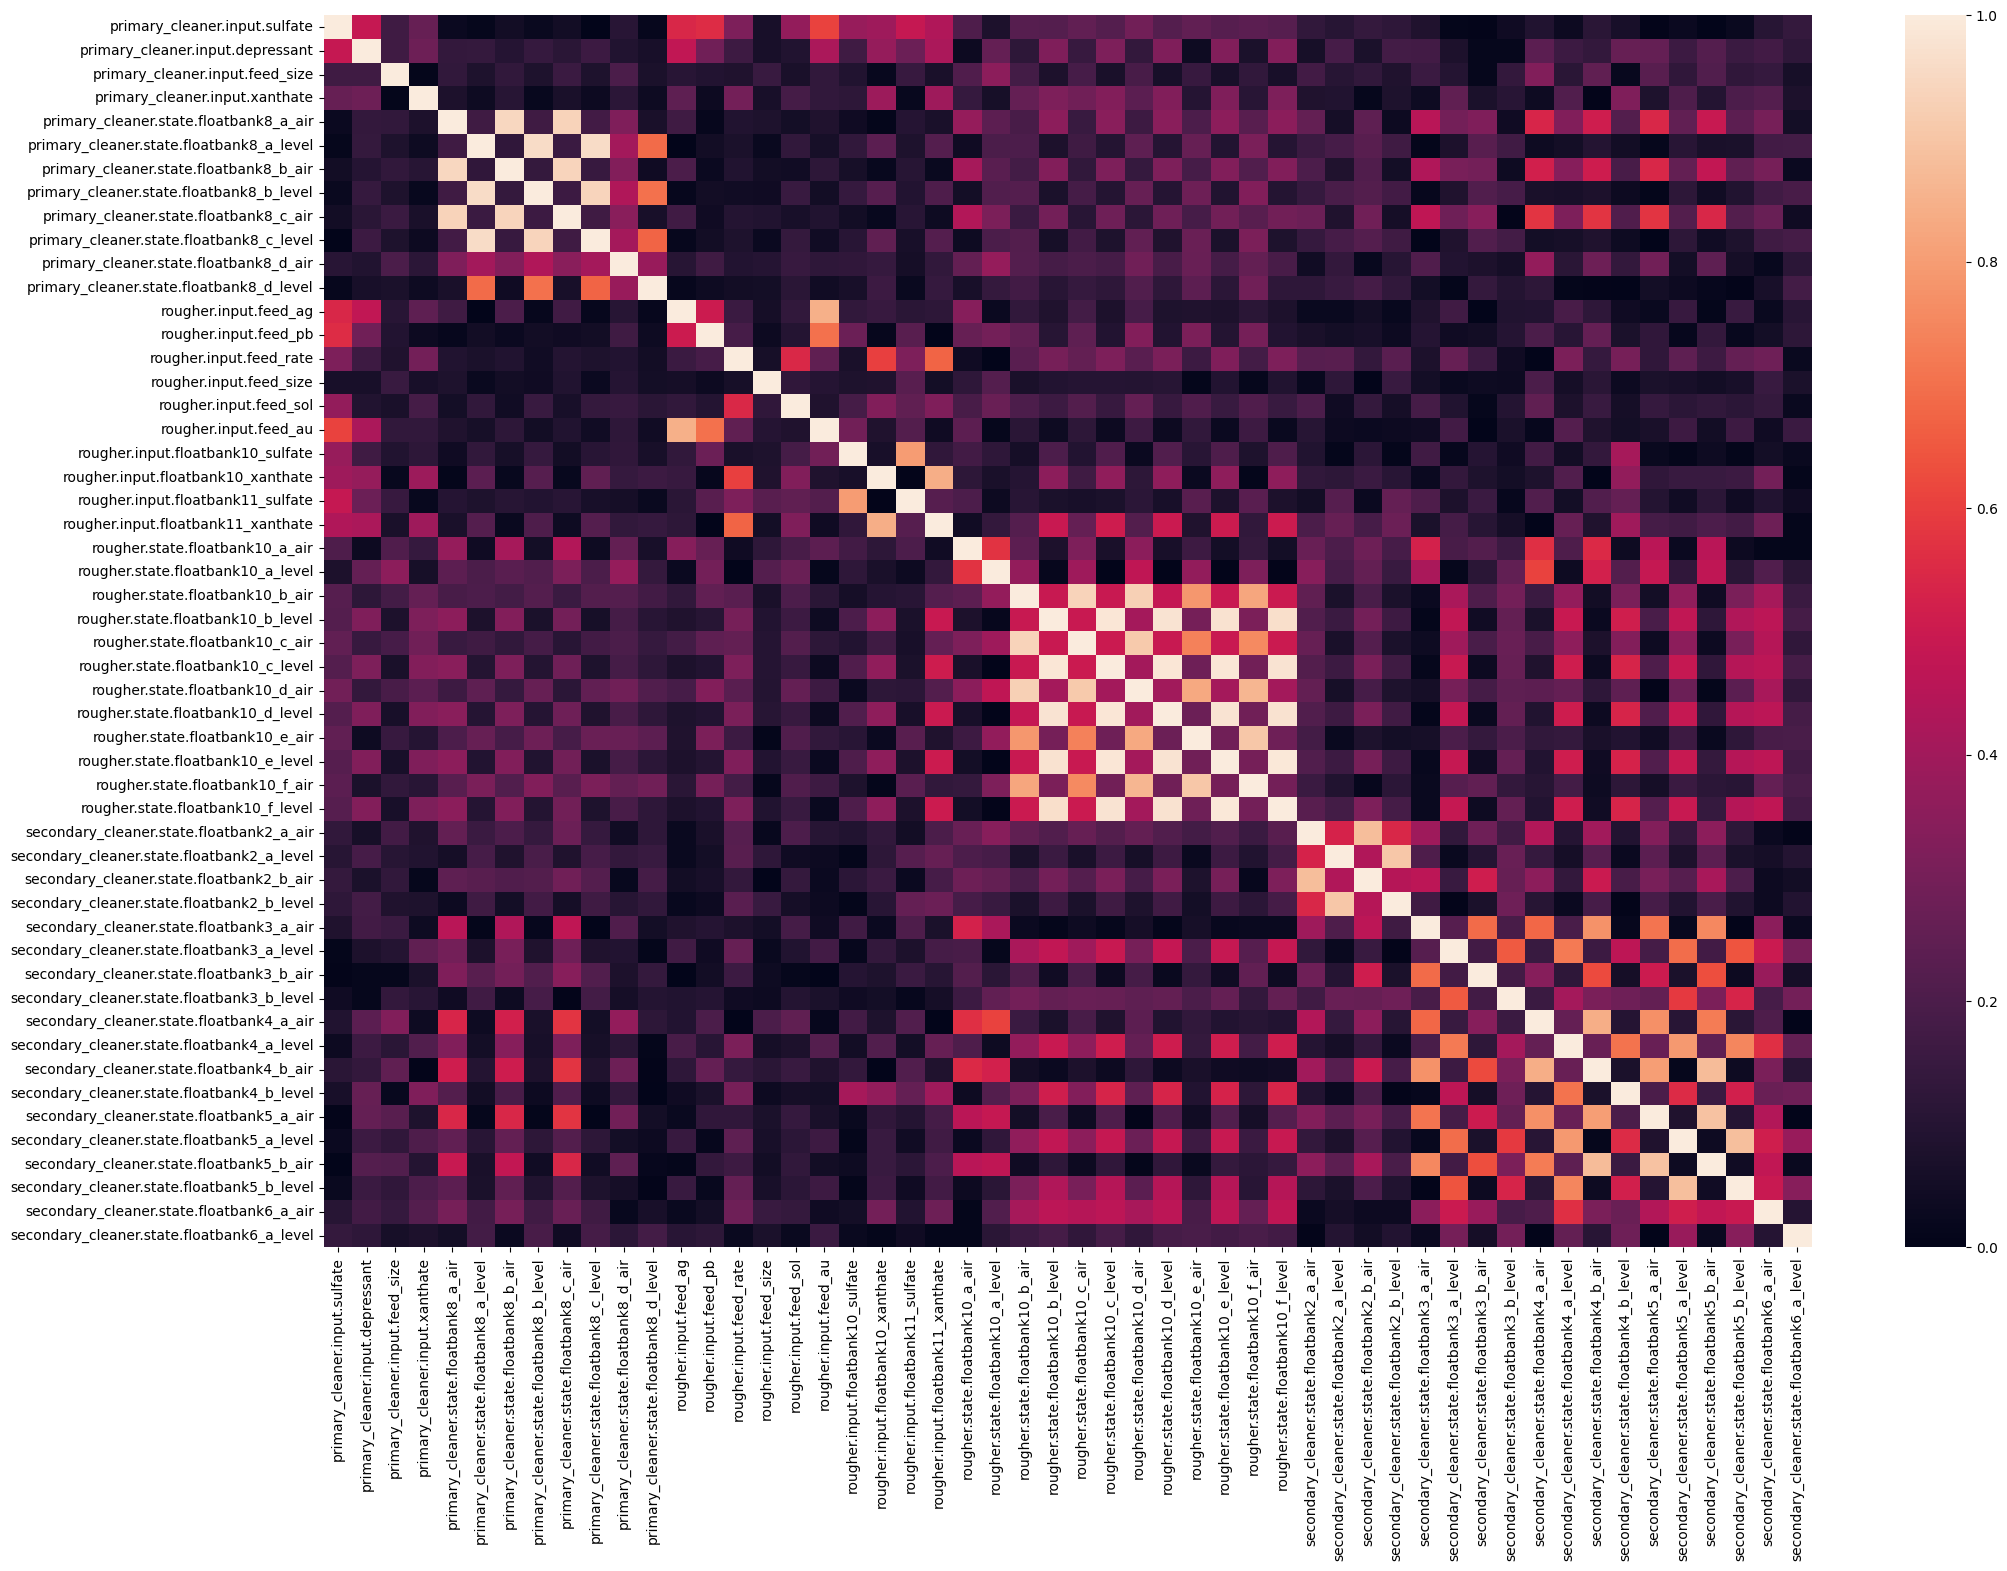

In [ ]:
plt.figure(figsize=(24, 16))
sns.heatmap(x1.corr().abs(), vmin=0)

Выбираем для удаления признаки с абсолютным значением корреляции выше порогового.

In [ ]:
threshold = 0.75
to_drop = (x1.corr().abs()[lambda x: x > threshold].sum()-1)[lambda x: x > 0]
print(to_drop.sort_values(ascending=False))
to_drop = to_drop.index

rougher.state.floatbank10_c_level             3.937537
rougher.state.floatbank10_e_level             3.923960
rougher.state.floatbank10_d_level             3.917774
rougher.state.floatbank10_f_level             3.907394
rougher.state.floatbank10_b_level             3.906829
rougher.state.floatbank10_d_air               3.529927
rougher.state.floatbank10_b_air               3.477956
rougher.state.floatbank10_f_air               3.346301
secondary_cleaner.state.floatbank4_b_air      3.298649
rougher.state.floatbank10_c_air               2.608040
rougher.state.floatbank10_e_air               2.522890
secondary_cleaner.state.floatbank5_b_air      2.521619
secondary_cleaner.state.floatbank5_a_air      2.466867
primary_cleaner.state.floatbank8_a_level      1.917228
primary_cleaner.state.floatbank8_b_level      1.897302
primary_cleaner.state.floatbank8_c_level      1.896819
primary_cleaner.state.floatbank8_b_air        1.884929
primary_cleaner.state.floatbank8_a_air        1.879830
primary_cl

Удаляем лишние признаки из выборок.

In [ ]:
x0 = x0.drop(to_drop, axis=1, errors='ignore')
x1 = x1.drop(to_drop, axis=1, errors='ignore')
xtest0 = xtest0.drop(to_drop, axis=1, errors='ignore')
xtest1 = xtest1.drop(to_drop, axis=1, errors='ignore')

<Axes: >

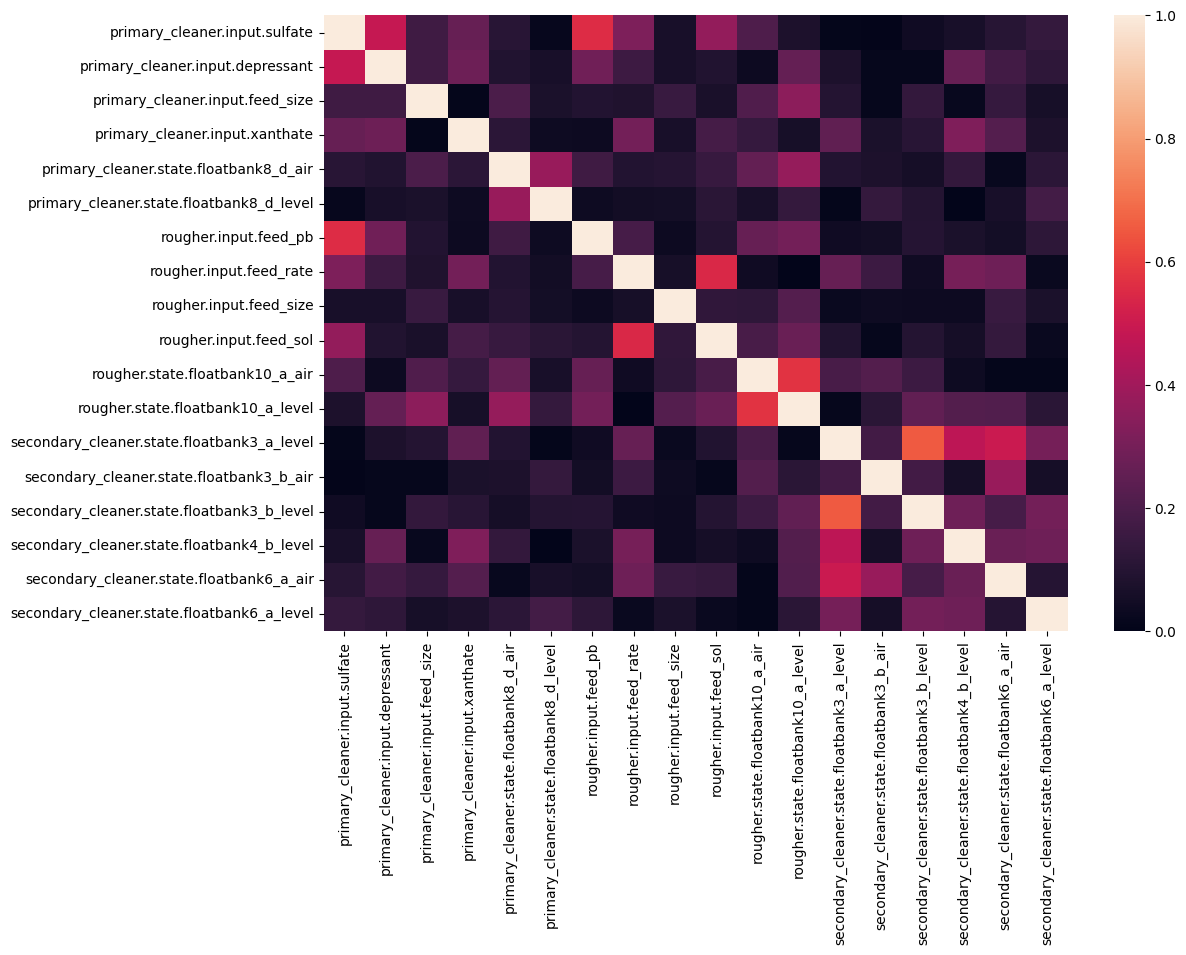

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(x1.corr().abs(), vmin=0)

Масштабируем признаки через `StandardScaler`.

In [ ]:
scaler = StandardScaler()
scaler.fit(x0)
x0 = scaler.transform(x0)
xtest0 = scaler.transform(xtest0)

scaler = StandardScaler()
scaler.fit(x1)
x1 = scaler.transform(x1)
xtest1 = scaler.transform(xtest1)

print(np.isclose(x0.mean(axis=0), 0).all(), np.isclose(x0.std(axis=0), 1).all())
print(np.isclose(x1.mean(axis=0), 0).all(), np.isclose(x1.std(axis=0), 1).all())

True True
True True


По результатам предобработки:
- Дубликатов не обнаружено;
- Пропуски заполнены интерполяцией по времени;
- Проверена правильность расчётов `recovery`;
- Выбраны признаки необходимые для обучения модели;
- Из выборок удалены признаки с высокой корреляцией;
- Признаки отмасштабированы.

## Анализ данных

Аббревиатуры:
- Au - Золото
- Ag - Серебро
- Pb - Свинец

In [ ]:
ms = ['au', 'ag', 'pb']
stages = ['rougher.input.feed',
          'rougher.output.concentrate',
          'primary_cleaner.output.concentrate',
          'final.output.concentrate']

pd.DataFrame([[full[f'{s}_{m}'].median() for m in ms] for s in stages],
             index=stages,
             columns=pd.Index([m.title() for m in ms])
            ).style.format(precision=2)

,Au,Ag,Pb
rougher.input.feed,8.13,8.59,3.53
rougher.output.concentrate,20.28,12.10,7.74
primary_cleaner.output.concentrate,32.84,8.51,10.14
final.output.concentrate,45.01,5.07,10.10


In [ ]:
data = full[[f'{s}_{m}' for m in ms for s in stages]].set_axis(
    pd.MultiIndex.from_product([ms, stages], names=['metal', 'stage']), axis=1)

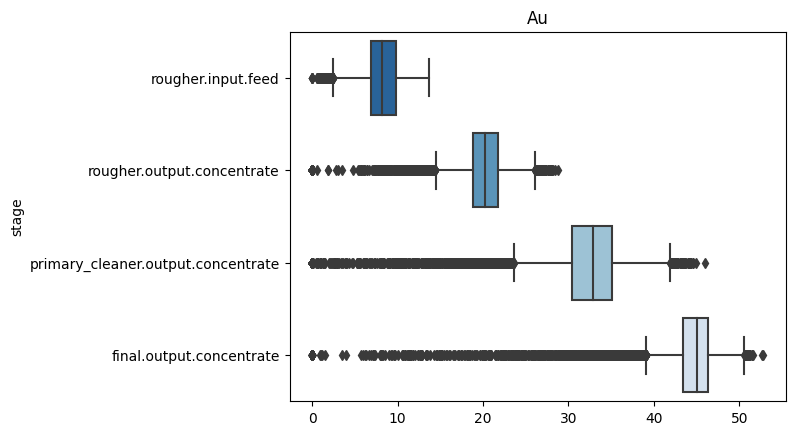

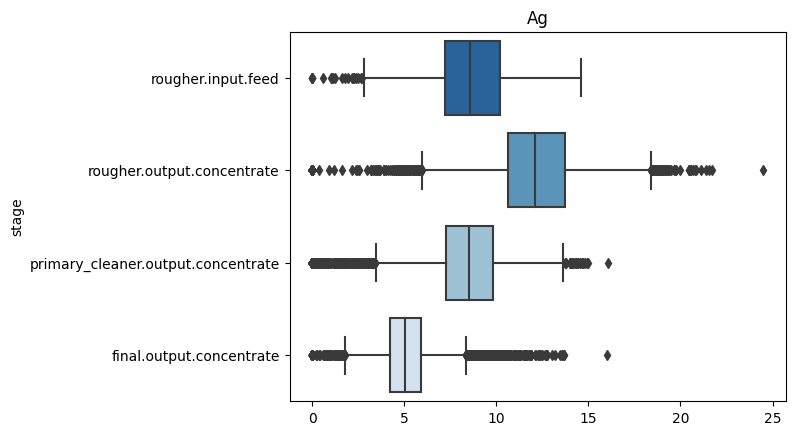

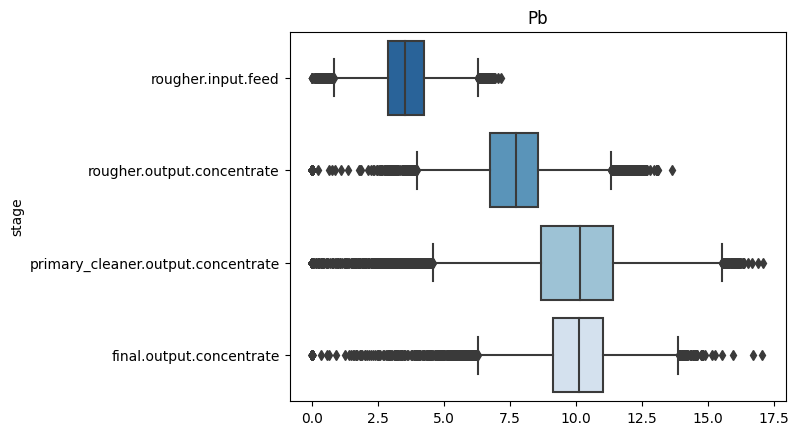

In [ ]:
for m in ms:
    sns.boxplot(data=data[m], orient='h', palette='Blues_r')
    plt.title(m.title())
    plt.show()

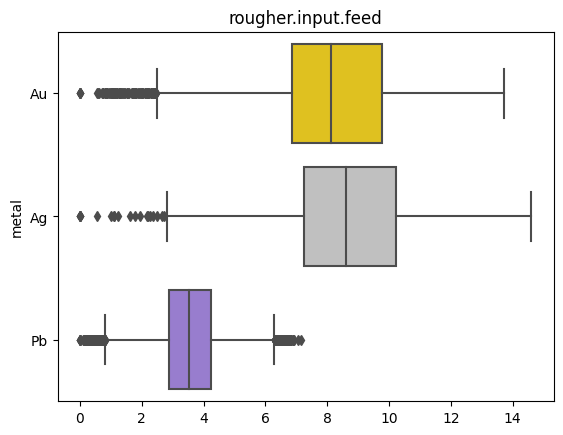

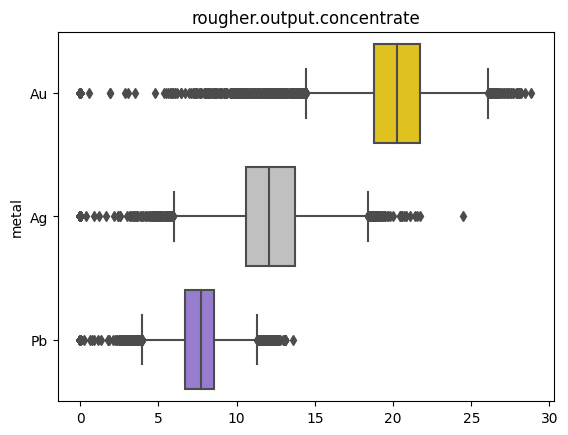

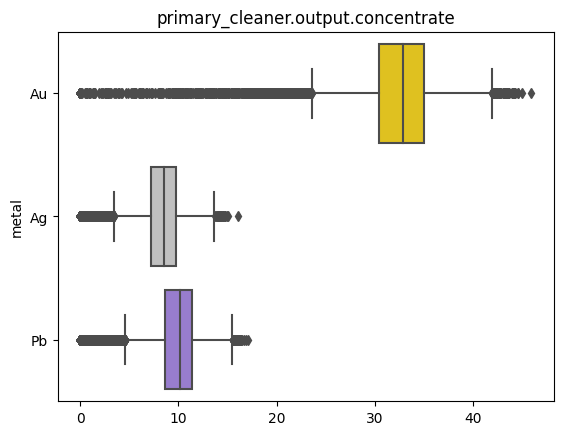

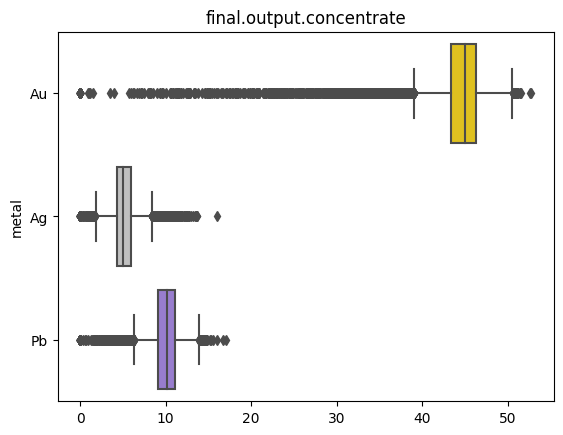

In [ ]:
colors = {'au': 'gold',
          'ag': 'silver',
          'pb': 'mediumpurple'}
for s in stages:
    sns.boxplot(data=data.xs(s, level=1, axis=1), orient='h', palette=colors)
    plt.yticks(range(3), map(str.title, ms))
    plt.title(s)
    plt.show()

Концентрация золота увеличивается почти линейно на каждом этапе. Концентрация серебра увеличивается после флотации, а затем уменьшается. Концентрация свинца увеличивается до этапа первичной очистки.

В итоговом концентрате золота примерно в 4.5 раз больше чем свинца и где-то в 9 раз больше чем серебра.

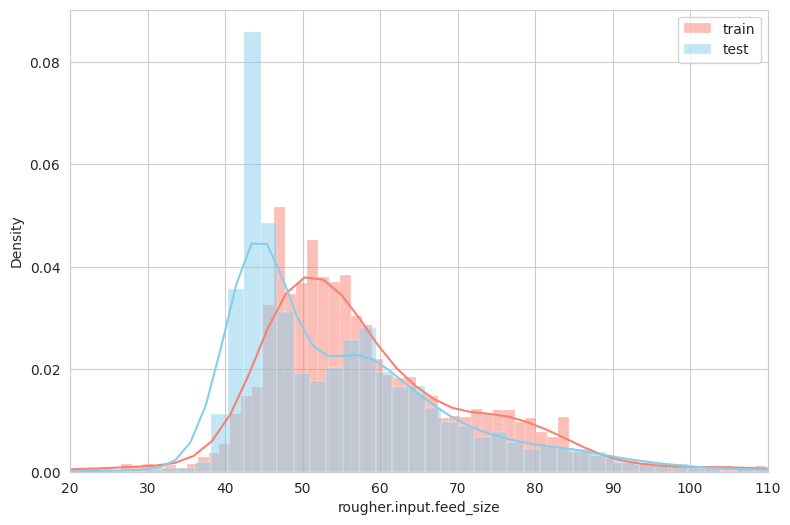

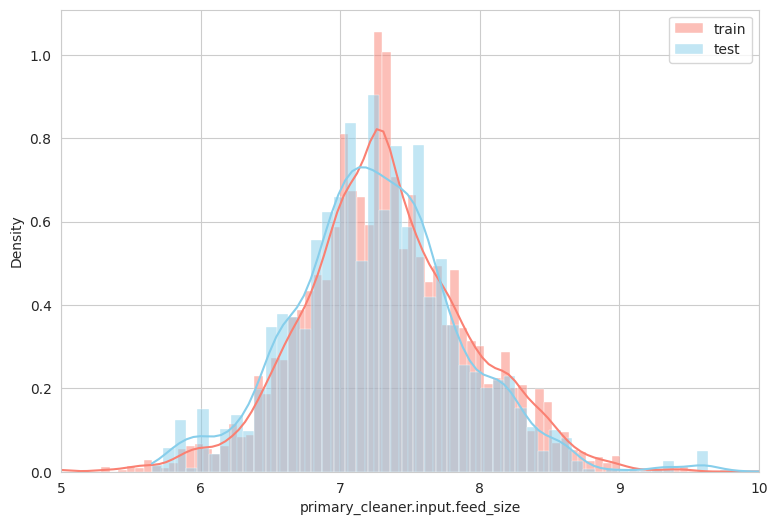

In [ ]:
cols = ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']
lims = [(20, 110), (5, 10)]

sns.set_style('whitegrid')
for c, l in zip(cols, lims):
    plt.figure(figsize=(9, 6))
    sns.histplot(data=train[c], label='train', color='salmon', kde=True, stat='density')
    sns.histplot(data=test[c], label='test', color='skyblue', kde=True, stat='density')
    plt.xlim(l)
    plt.legend()
    plt.show()

Распределения размеров гранул на обучающей и тестовой выборках очень похожи.

<Axes: >

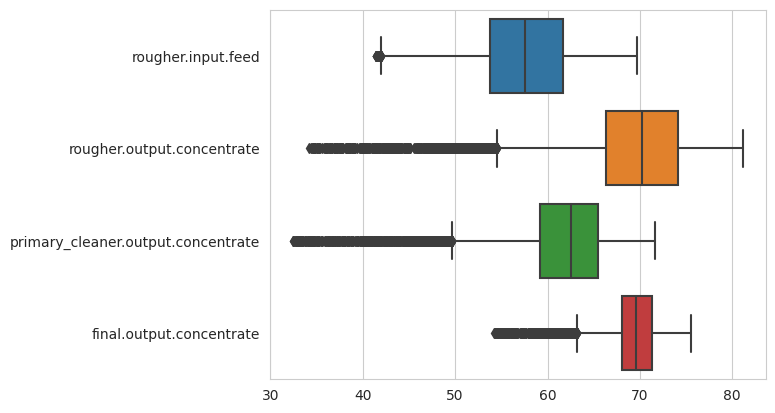

In [ ]:
# Убираем аномальные значения, оставляя 95% от выборок.
alpha = 0.95
a = (1 - alpha) / 2
b = 1 - a

data = pd.DataFrame([sum(full[f'{s}_{m}'] for m in ms + ['sol'])
                     [lambda x: (x.quantile(a) < x) & (x < x.quantile(b))]
                     for s in stages],
                    index=stages).T
sns.boxplot(data=data, orient='h')

Общая концентрация веществ увеличивается после флотации, затем уменьшается после первичной очистки. У финального продукта концентрация веществ похожа на ту, что была после флотации, но с меньшим разбросом значений.

## Модель

### Обучение

In [ ]:
def smape(true, pred):
    if isinstance(true, pd.DataFrame):
        true = true.values

    s = np.divide(abs(true - pred) * 2, (abs(true) + abs(pred)),
            where=true!=pred, out=np.zeros(true.shape, dtype=float)).mean(axis=0)

    if isinstance(s, float):
        return s * 100
    return (s[0] * 0.25 + s[1] * 0.75) * 100

smape_score = make_scorer(smape, greater_is_better=False)

In [ ]:
data = [(x0, y0), (x1, y1)]
data_test = [(xtest0, ytest0), (xtest1, ytest1)]
names = ['Rougher', 'Final']

In [ ]:
%%time

models = []
for name, (x, y) in zip(names, data):
    print(f'{f" {name} Recovery ":=^37}')

    for s in ['mean', 'median']:
        model = DummyRegressor(strategy=s)
        res = cross_val_score(model, x, y, cv=3, scoring=smape_score, n_jobs=-1)
        print(f'DummyRegressor {f"({s})":8}       : {-res.mean():5.2f}')

    model = LinearRegression()
    res = cross_val_score(model, x, y, cv=3, scoring=smape_score, n_jobs=-1)
    best_score = -res.mean()
    print(f'LinearRegression              : {best_score:5.2f}')
    best_model = LinearRegression()
    best_model.fit(x, y)

    model = DecisionTreeRegressor(random_state=seed)
    ccp_alphas = model.cost_complexity_pruning_path(x, y).ccp_alphas
    search = RandomizedSearchCV(model,
                                dict(criterion=['squared_error',
                                                'friedman_mse',
                                                'absolute_error',
                                                'poisson'],
                                     splitter=['best', 'random'],
                                     max_depth=range(1, 21),
                                     min_samples_split=range(2, 6),
                                     min_samples_leaf=range(1, 6),
                                     ccp_alpha=ccp_alphas),
                                random_state=seed, scoring=smape_score, cv=3, n_jobs=-1,
                                n_iter=10)
    search.fit(x, y)
    score = -search.best_score_
    print(f'DecisionTreeRegressor         : {score:5.2f}')
    if score < best_score:
        best_score = score
        best_model = search.best_estimator_

    model = RandomForestRegressor(random_state=seed)
    search = RandomizedSearchCV(model,
                                dict(n_estimators=range(10, 101, 10),
                                     criterion=['squared_error',
                                                'friedman_mse',
                                                'absolute_error',
                                                'poisson'],
                                     max_depth=range(1, 11),
                                     min_samples_split=range(2, 6),
                                     min_samples_leaf=range(1, 6)),
                                random_state=seed, scoring=smape_score, cv=3, n_jobs=-1,
                                n_iter=10)
    search.fit(x, y)
    score = -search.best_score_
    print(f'RandomForestRegressor         : {score:5.2f}')
    if score < best_score:
        best_score = score
        best_model = search.best_estimator_

    model = HistGradientBoostingRegressor(random_state=seed)
    search = RandomizedSearchCV(model,
                                dict(max_iter=range(10, 101, 10),
                                     loss=['squared_error',
                                           'absolute_error',
                                           'poisson'],
                                     max_depth=range(1, 11),
                                     min_samples_leaf=range(1, 6)),
                                random_state=seed,
                                scoring=smape_score,
                                cv=3,
                                n_jobs=-1,
                                n_iter=10)
    search.fit(x, y)
    score = -search.best_score_
    print(f'HistGradientBoostingRegressor : {score:5.2f}')
    if score < best_score:
        best_score = score
        best_model = search.best_estimator_

    models.append(best_model)
print('='*37)

========= Rougher Recovery ==========
DummyRegressor (mean)         : 11.82
DummyRegressor (median)       : 11.36
LinearRegression              : 10.51
DecisionTreeRegressor         :  9.04
RandomForestRegressor         :  9.63
HistGradientBoostingRegressor :  8.50
========== Final Recovery ===========
DummyRegressor (mean)         : 11.12
DummyRegressor (median)       : 11.04
LinearRegression              :  9.88
DecisionTreeRegressor         :  8.54
RandomForestRegressor         :  7.98
HistGradientBoostingRegressor :  7.66
CPU times: user 54.1 s, sys: 588 ms, total: 54.7 s
Wall time: 5min 35s


### Тестирование

In [ ]:
print(f'{" Best Models ":=^88}')
for i, model in enumerate(models):
    print(f'Model {i}: {model}')

===================================== Best Models ======================================
Model 0: HistGradientBoostingRegressor(loss='absolute_error', max_depth=7, max_iter=70,
                              min_samples_leaf=1, random_state=666)
Model 1: HistGradientBoostingRegressor(loss='absolute_error', max_depth=7, max_iter=70,
                              min_samples_leaf=1, random_state=666)


In [ ]:
pred = models[0].predict(xtest0)
s0 = smape(ytest0, pred)

pred = models[1].predict(xtest1)
s1 = smape(ytest1, pred)

print('Rougher :', s0)
print('Final   :', s1)
print('Total   :', s0 * 0.25 + s1 * 0.75)

Rougher : 8.090692351826007
Final   : 8.605443418966988
Total   : 8.476755652181744


In [ ]:
model = DummyRegressor(strategy='median')
model.fit(x0, y0)
pred = model.predict(xtest0)
s0 = smape(ytest0, pred)

model = DummyRegressor(strategy='median')
model.fit(x1, y1)
pred = model.predict(xtest1)
s1 = smape(ytest1, pred)

print('Rougher :', s0)
print('Final   :', s1)
print('Total   :', s0 * 0.25 + s1 * 0.75)

Rougher : 8.627729267935692
Final   : 9.763982508185249
Total   : 9.47991919812286


## Вывод

Получены хорошие модели. Итоговые модели предсказывают лучше, чем среднее или медиана. sMAPE для чернового концентрата на тестовой выборке чуть лучше чем на валидационной, а для финального концентрата чуть хуже.